In [35]:
import bagpy
from bagpy import bagreader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from functools import reduce
from scipy.spatial.transform import Rotation
import ipympl

%matplotlib widget

sns.set_theme()
# LaTex must be installed for this to work
# sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

plt.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{bm}')

def drop_columns_in_df(df):
    return df.drop(columns=["header.seq", "header.stamp.secs", "header.stamp.nsecs", "header.frame_id"])

def rename_columns(df, new_colum_names: list):
    column_names = ['Time'] + new_colum_names
    
    df.columns= column_names

    return df

def normalize_df_time(df):
    start_time = df['Time'].iloc[0]

    df['Time'] -= start_time

    return df

def sync_dfs_based_on_time(dataframes: list):
    import math
    earliest_time = math.inf
    for frame in dataframes:
        if frame.iloc[0]["Time"] < earliest_time:
            earliest_time = frame.iloc[0]["Time"]

    for frame in dataframes:
        frame['Time'] -= earliest_time

    return dataframes

def df_from_pose_to_euler(df):
    quat_df = df[['pose.orientation.x', 'pose.orientation.y', 'pose.orientation.z', 'pose.orientation.w']]
    rot = Rotation.from_quat(quat_df)
    rot_euler = rot.as_euler('xyz', degrees=True)
    euler_df = pd.DataFrame(data=rot_euler, columns=['roll', 'pitch', 'yaw'])

    conc = [df, euler_df]

    df_gt_euler = pd.concat(
        conc,
        axis=1,
        join="outer",
        ignore_index=False,
        keys=None,
        levels=None,
        names=None,
        verify_integrity=False,
        copy=True,
    )

    df_gt_euler = drop_columns_in_df(df_gt_euler)
    df_gt_euler.drop(columns=["pose.position.x", "pose.position.y", "pose.position.z", "pose.orientation.x", "pose.orientation.y","pose.orientation.z","pose.orientation.w"], inplace=True)

    return df_gt_euler

def Mask_Or_Drop_Successive_Identical_Values(df, drop=False, 
                                             keep_first=True,
                                             axis=0):

    '''
    Input:
    df should be a pandas.DataFrame of a a pandas.Series
    Output:
    df of ts with masked or dropped values
    '''
    
    # Mask keeping the first occurrence
    if keep_first:
        df = df.mask(df.shift(1) == df)
    # Mask including the first occurrence
    else:
        df = df.mask((df.shift(1) == df) | (df.shift(-1) == df))

    # Drop the values (e.g. rows are deleted)    
    if drop:
        return df.dropna(axis=axis)        
    # Only mask the values (e.g. become 'NaN')
    else:
        return df

def get_np_arr_without_nan(df_list, datacols_list, remove_identicals=True):
    np_column = np.array(["Time"] + datacols_list)
    for i in range(len(df_list)):
        if df_list[i].columns.shape == np_column.shape:
            if np.all(df_list[i].columns == np_column):
                df = df_list[i]

    if remove_identicals:
      df_with_NAN = Mask_Or_Drop_Successive_Identical_Values(df)
    else:
      df_with_NAN = df

    column_names = ['Time'] + datacols_list

    selected_rows = df_with_NAN[~df_with_NAN[datacols_list[0]].isnull()]
    reduced_df_without_NAN = selected_rows[column_names]

    return reduced_df_without_NAN.to_numpy()

def ret_track_df(df):
    # create an empty list to store DataFrames
    dfs = []

    # iterate over rows of the original DataFrame
    for index, row in df.iterrows():
        # split the bounding boxes string into individual boxes
        bbs = row['bbs'].replace('[','').replace(']','').split(', ')
        # create a DataFrame for each box and append it to the list of DataFrames
        for bb in bbs:
            bb_dict = {}
            for item in bb.split("\n"):
                key, value = item.split(": ")
                bb_dict[key.strip()] = float(value) if key.strip() not in ["id", "Class"] else value.strip().replace('"', '')
            new_row = {**row.to_dict(), **bb_dict}
            dfs.append(pd.DataFrame(new_row, index=[index]))

    # concatenate the list of DataFrames into a single DataFrame
    new_df = pd.concat(dfs, axis=0, ignore_index=True)

    new_df = new_df[["Time", "probability",	"xmin",	"ymin",	"xmax",	"ymax",	"id",	"Class"]]

    new_df['id'] = new_df['id'].astype(int)

    # extract the desired columns using loc
    new_df = new_df.loc[:, ['Time', 'id', 'probability', 'Class', 'xmin', 'ymin', 'xmax', 'ymax']]

    # calculate the center x and y coordinates
    new_df['center_x'] = (new_df['xmin'] + new_df['xmax']) / 2
    new_df['center_y'] = (new_df['ymin'] + new_df['ymax']) / 2

    # drop the original xmin, ymin, xmax, ymax columns
    new_df.drop(columns=['xmin', 'ymin', 'xmax', 'ymax'], inplace=True)

    return new_df

def remove_parentheses(string):
    return string.replace('(', '').replace(')', '')

# Define a function to extract the first three elements on the diagonal
def extract_diagonal(row):
    elements = row['pose.covariance'].split(',')
    return pd.Series([float(remove_parentheses(elements[0])), float(elements[7]), float(remove_parentheses(elements[14]))])

In [56]:
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/square/no_perception/2022-11-08-11-56-31.bag')
# b = bagreader('/Users/simenallum/Library/CloudStorage/OneDrive-NTNU/Project thesis - bagfiles/lab/mission/no_perception/2022-11-08-11-19-46.bag')
b = bagreader('/home/msccomputer/Desktop/2023-04-18-09-53-08.bag')
b.topic_table

[INFO]  Successfully created the data folder /home/msccomputer/Desktop/2023-04-18-09-53-08.


,Topics,Types,Message Count,Frequency
0,/anafi/attitude,geometry_msgs/QuaternionStamped,1164,43.340780
1,/anafi/gnss_location,sensor_msgs/NavSatFix,1164,44.689191
2,/anafi/height,olympe_bridge/Float32Stamped,1164,43.756758
3,/anafi/image,sensor_msgs/Image,1165,45.504939
4,/anafi/ned_pos_from_gnss,geometry_msgs/PointStamped,1164,44.812855
5,/anafi/pose,geometry_msgs/PoseStamped,1164,44.318512
6,/anafi/rpy,geometry_msgs/Vector3Stamped,2368,137.789225
7,/clock,rosgraph_msgs/Clock,3667,98.882618
8,/qualisys/AT0/pose,geometry_msgs/PoseStamped,3819,197.928555
9,/qualisys/Anafi/pose,geometry_msgs/PoseStamped,3892,188.338752


In [50]:
anafi_pos_from_gnss = b.message_by_topic('/anafi/ned_pos_from_gnss')
df_anafi_pos_from_gnss = pd.read_csv(anafi_pos_from_gnss)

df_anafi_pos_from_gnss = rename_columns(df_anafi_pos_from_gnss[["Time", "point.x",	"point.y",	"point.z"]], ["x", "y", "z"])

df_anafi_pos_from_gnss

,Time,x,y,z
0,1.681804e+09,-0.071734,-0.028020,-2.497350
1,1.681804e+09,-0.071300,-0.028094,-2.496578
2,1.681804e+09,-0.070929,-0.027948,-2.495855
3,1.681804e+09,-0.070929,-0.027948,-2.495855
4,1.681804e+09,-0.070648,-0.027761,-2.495302
...,...,...,...,...
1154,1.681804e+09,-0.077078,-0.019338,-2.507118
1155,1.681804e+09,-0.076871,-0.019522,-2.507719
1156,1.681804e+09,-0.076871,-0.019522,-2.507719
1157,1.681804e+09,-0.076382,-0.019744,-2.508040


In [51]:
df_merged_anafi_pos = sync_dfs_based_on_time([df_anafi_pos_from_gnss])

df_merged_anafi_pos = normalize_df_time(df_merged_anafi_pos)

df_merged_anafi_pos

np_anafi_pos_from_gnss = get_np_arr_without_nan(df_merged_anafi_pos, ["x", "y", "z"], remove_identicals=True)

print(np_anafi_pos_from_gnss[0])
print(np_anafi_pos_from_gnss[-1])
print(len(np_anafi_pos_from_gnss))


TypeError: list indices must be integers or slices, not str

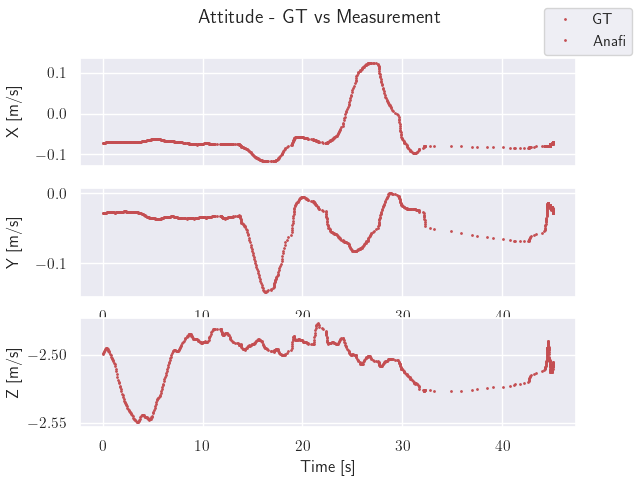

In [ ]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,1],'o', ms=1, c='r')

axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,2],'o', ms=1, c='r')

# axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)
# axs[1].set_xticklabels([])



axs[2].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,3],'o', ms=1, c='r')

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Compare GT vs Anafi attitude

In [308]:
anafi_attitude = b.message_by_topic('/anafi/pose')
df_anafi_attitude = pd.read_csv(anafi_attitude)

df_anafi_attitude = df_from_pose_to_euler(df_anafi_attitude)

df_anafi_attitude = rename_columns(df_anafi_attitude, ["anafi_roll", "anafi_pitch", "anafi_yaw"])

df_anafi_attitude


,Time,anafi_roll,anafi_pitch,anafi_yaw
0,1.679407e+09,-1.281819,0.240777,0.283564
1,1.679407e+09,-1.253835,0.219748,0.290856
2,1.679407e+09,-1.218876,0.191704,0.298212
3,1.679407e+09,-1.204831,0.191687,0.305316
4,1.679407e+09,-1.183628,0.191702,0.333460
...,...,...,...,...
1047,1.679407e+09,-1.380876,0.434165,4.381795
1048,1.679407e+09,-1.370088,0.428682,4.795120
1049,1.679407e+09,-1.359646,0.443556,5.082288
1050,1.679407e+09,-1.328748,0.443446,5.376718


In [309]:
gt_anafi_attitude = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_attitude = pd.read_csv(gt_anafi_attitude)

df_gt_anafi_attitude = df_from_pose_to_euler(df_gt_anafi_attitude)
df_gt_anafi_attitude = rename_columns(df_gt_anafi_attitude, ["gt_anafi_roll", "gt_anafi_pitch", "gt_anafi_yaw"])

df_gt_anafi_attitude

,Time,gt_anafi_roll,gt_anafi_pitch,gt_anafi_yaw
0,1.679407e+09,0.097851,-0.126495,-1.387957
1,1.679407e+09,0.193256,-0.063101,-1.376785
2,1.679407e+09,0.178470,-0.085220,-1.409513
3,1.679407e+09,0.236027,-0.122823,-1.383235
4,1.679407e+09,0.220609,-0.111936,-1.385548
...,...,...,...,...
3494,1.679407e+09,0.281942,0.146621,4.471835
3495,1.679407e+09,0.288202,0.144305,4.584436
3496,1.679407e+09,0.301306,0.107083,4.675683
3497,1.679407e+09,0.305835,0.123883,4.759709


In [310]:
anafi_rpy = b.message_by_topic('/anafi/rpy')
df_anafi_rpy = pd.read_csv(anafi_rpy)

df_anafi_rpy['vector.x'] = np.rad2deg(df_anafi_rpy['vector.x'])
df_anafi_rpy['vector.y'] = np.rad2deg(df_anafi_rpy['vector.y'])
df_anafi_rpy['vector.z'] = np.rad2deg(df_anafi_rpy['vector.z'])

df_anafi_rpy = rename_columns(df_anafi_rpy[["Time", "vector.x", "vector.y", "vector.z"]], ["anafi_roll_rpy", "anafi_pitch_rpy", "anafi_yaw_rpy"])

df_anafi_rpy


,Time,anafi_roll_rpy,anafi_pitch_rpy,anafi_yaw_rpy
0,1.679407e+09,-0.410391,0.957607,0.278590
1,1.679407e+09,-0.410391,0.957607,0.278590
2,1.679407e+09,-0.410391,0.957607,0.278590
3,1.679407e+09,-0.410391,0.957607,0.278590
4,1.679407e+09,-0.410391,0.957607,0.278590
...,...,...,...,...
2321,1.679407e+09,-0.498642,1.132741,3.949359
2322,1.679407e+09,-0.498642,1.132741,3.949359
2323,1.679407e+09,-0.498642,1.132741,3.949359
2324,1.679407e+09,-0.498642,1.132741,3.949359


In [311]:
df_merged_attitude = sync_dfs_based_on_time([df_gt_anafi_attitude, df_anafi_attitude, df_anafi_rpy])


df_merged_attitude = normalize_df_time(df_merged_attitude)

df_merged_attitude


np_gt_anafi_attitude = get_np_arr_without_nan(df_merged_attitude, ["gt_anafi_roll",	"gt_anafi_pitch",	"gt_anafi_yaw"])
np_anafi_attitude = get_np_arr_without_nan(df_merged_attitude, ["anafi_roll",	"anafi_pitch",	"anafi_yaw"])
np_anafi_rpy = get_np_arr_without_nan(df_merged_attitude, ["anafi_roll_rpy", "anafi_pitch_rpy", "anafi_yaw_rpy"], remove_identicals=False)



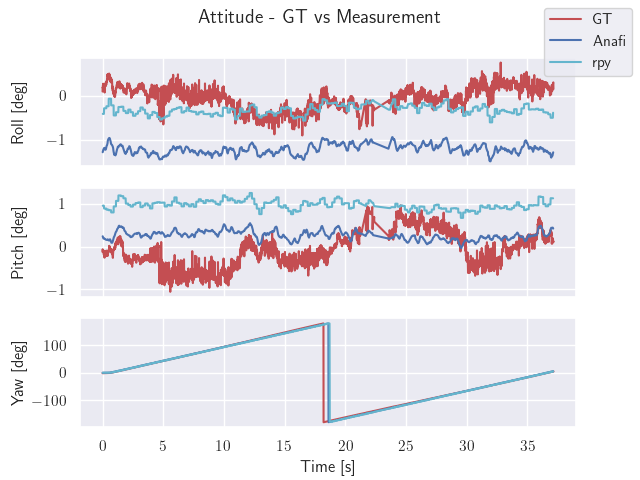

In [313]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,1],'-', ms=1, c='r')
axs[0].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,1],'-', ms=1, c='b')
axs[0].plot(np_anafi_rpy[:,0], np_anafi_rpy[:,1],'-', ms=1, c='c')


axs[0].set_ylabel('Roll [deg]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,2],'-', ms=1, c='r')
axs[1].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,2],'-', ms=1, c='b')
axs[1].plot(np_anafi_rpy[:,0], np_anafi_rpy[:,2],'-', ms=1, c='c')


axs[1].set_xticklabels([])
axs[1].set_ylabel('Pitch [deg]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].plot(np_gt_anafi_attitude[:,0], np_gt_anafi_attitude[:,3],'-', ms=1, c='r')
axs[2].plot(np_anafi_attitude[:,0], np_anafi_attitude[:,3],'-', ms=1, c='b')
axs[2].plot(np_anafi_rpy[:,0], np_anafi_rpy[:,3],'-', ms=1, c='c')


axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Yaw [deg]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi", "rpy"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Check GT angular velocity

In [172]:
gt_anafi_odom = b.message_by_topic('/qualisys/Anafi/odom')
df_gt_anafi_odom = pd.read_csv(gt_anafi_odom)

df_gt_anafi_odom

df_gt_anafi_odom = rename_columns(df_gt_anafi_odom[["Time", "twist.twist.angular.x", "twist.twist.angular.y", "twist.twist.angular.z"]], ["angular_vel_x", "angular_vel_y", "angular_vel_z"])

df_gt_anafi_odom


,Time,angular_vel_x,angular_vel_y,angular_vel_z
0,1.679418e+09,-0.147158,0.305084,0.144102
1,1.679418e+09,0.099895,-0.078462,0.006426
2,1.679418e+09,0.137859,-0.065286,-0.043439
3,1.679418e+09,0.044308,-0.092672,-0.076953
4,1.679418e+09,0.094388,-0.053214,-0.043009
...,...,...,...,...
4326,1.679419e+09,-0.126363,0.303180,0.122666
4327,1.679419e+09,-0.083032,-0.021998,-0.039046
4328,1.679419e+09,0.009708,-0.086324,-0.059661
4329,1.679419e+09,-0.064091,-0.166740,-0.043303


In [173]:
df_merged_odom = sync_dfs_based_on_time([df_gt_anafi_odom])

df_merged_odom = normalize_df_time(df_merged_odom)

np_gt_anafi_odom = get_np_arr_without_nan(df_merged_odom, ["angular_vel_x", "angular_vel_y", "angular_vel_z"])


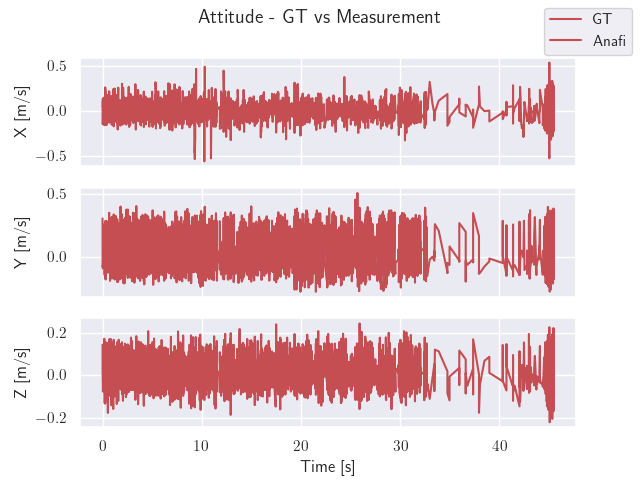

In [174]:
fig, axs = plt.subplots(3, 1)

axs[0].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,1],'-', ms=1, c='r')

axs[0].set_ylabel('X [m/s]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,2],'-', ms=1, c='r')

axs[1].set_xticklabels([])
axs[1].set_ylabel('Y [m/s]')
axs[1].grid(True)
axs[1].set_xticklabels([])



axs[2].plot(np_gt_anafi_odom[:,0], np_gt_anafi_odom[:,3],'-', ms=1, c='r')

axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('Z [m/s]')
axs[2].grid(True)

handles, labels = axs[2].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Attitude - GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Check Anafi position

In [175]:
gt_anafi_pos = b.message_by_topic('/qualisys/Anafi/pose')
df_gt_anafi_pos = pd.read_csv(gt_anafi_pos)

df_gt_anafi_pos = rename_columns(df_gt_anafi_pos[["Time", "pose.position.x",	"pose.position.y",	"pose.position.z"]], ["gt_x", "gt_y", "gt_z"])

df_gt_anafi_pos

,Time,gt_x,gt_y,gt_z
0,1.679418e+09,-0.072786,-0.027022,-2.498889
1,1.679418e+09,-0.072829,-0.027046,-2.499029
2,1.679418e+09,-0.072761,-0.027085,-2.499177
3,1.679418e+09,-0.072856,-0.027034,-2.499103
4,1.679418e+09,-0.072744,-0.026952,-2.499180
...,...,...,...,...
4326,1.679419e+09,-0.068607,-0.028629,-2.505754
4327,1.679419e+09,-0.068629,-0.028263,-2.505997
4328,1.679419e+09,-0.068615,-0.028337,-2.506004
4329,1.679419e+09,-0.068491,-0.028169,-2.506051


In [176]:
anafi_pos_from_gnss = b.message_by_topic('/anafi/ned_pos_from_gnss')
df_anafi_pos_from_gnss = pd.read_csv(anafi_pos_from_gnss)

df_anafi_pos_from_gnss = rename_columns(df_anafi_pos_from_gnss[["Time", "point.x",	"point.y",	"point.z"]], ["x", "y", "z"])

df_anafi_pos_from_gnss

,Time,x,y,z
0,1.679418e+09,-0.072437,-0.027978,-2.499107
1,1.679418e+09,-0.072095,-0.028259,-2.498360
2,1.679418e+09,-0.072095,-0.028259,-2.498360
3,1.679418e+09,-0.071949,-0.027922,-2.498049
4,1.679418e+09,-0.071734,-0.028020,-2.497350
...,...,...,...,...
1283,1.679419e+09,-0.069560,-0.028040,-2.505670
1284,1.679419e+09,-0.069367,-0.028115,-2.505918
1285,1.679419e+09,-0.069058,-0.028244,-2.505844
1286,1.679419e+09,-0.069058,-0.028244,-2.505844


In [177]:
df_merged_anafi_pos = sync_dfs_based_on_time([df_gt_anafi_pos, df_anafi_pos_from_gnss])

df_merged_anafi_pos = normalize_df_time(df_merged_anafi_pos)

df_merged_anafi_pos


np_gt_anafi_pos = get_np_arr_without_nan(df_merged_anafi_pos, ["gt_x", "gt_y", "gt_z"])
np_anafi_pos_from_gnss = get_np_arr_without_nan(df_merged_anafi_pos, ["x", "y", "z"], remove_identicals=False)

np_anafi_pos_from_gnss

array([[ 3.17553520e-01, -7.24372020e-02, -2.79782505e-02,
        -2.49910693e+00],
       [ 3.27819824e-01, -7.24372020e-02, -2.79782505e-02,
        -2.49910693e+00],
       [ 3.57522011e-01, -7.20951388e-02, -2.82592373e-02,
        -2.49836011e+00],
       ...,
       [ 4.54307382e+01, -6.86071860e-02, -2.86294423e-02,
        -2.50575366e+00],
       [ 4.54307530e+01, -6.86071860e-02, -2.86294423e-02,
        -2.50575366e+00],
       [ 4.54307642e+01, -6.86071860e-02, -2.86294423e-02,
        -2.50575366e+00]])

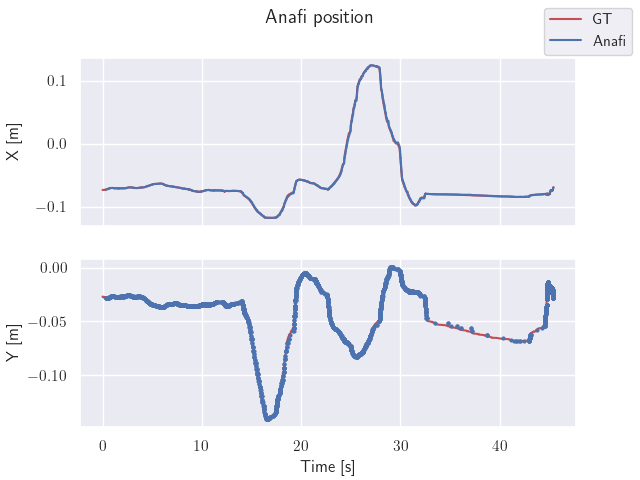

In [178]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_gt_anafi_pos[:,0], np_gt_anafi_pos[:,1],'-', ms=1, c='r')
axs[0].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,1],'-', ms=1, c='b')


axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_anafi_pos[:,0], np_gt_anafi_pos[:,2],'-', ms=1, c='r')
axs[1].plot(np_anafi_pos_from_gnss[:,0], np_anafi_pos_from_gnss[:,2],'o', ms=2, c='b')


axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["GT", "Anafi"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('Anafi position', fontsize=14)
fig.align_ylabels(axs)

plt.show()

# Evaluate algorithm

In [57]:
tracks_coord = b.message_by_topic('/search/tracks/world_coordinates')
df_tracks_coord = pd.read_csv(tracks_coord)

df_tracks_coord = df_tracks_coord[["Time", "x", "y", "z"]]

df_tracks_coord

,Time,x,y,z
0,1.681804e+09,-0.221398,1.610661,-0.018908
1,1.681804e+09,-0.215716,1.594809,-0.022326
2,1.681804e+09,-0.210782,1.577470,-0.027470
3,1.681804e+09,-0.204071,1.566238,-0.025794
4,1.681804e+09,-0.199196,1.553883,-0.025794
...,...,...,...,...
828,1.681804e+09,0.851998,-1.375968,-0.029923
829,1.681804e+09,0.853917,-1.388048,-0.029923
830,1.681804e+09,0.855837,-1.400128,-0.029923
831,1.681804e+09,0.857929,-1.412089,-0.029923


In [58]:
# tracks_coord_fov = b.message_by_topic("/search/tracks/world_coordinates_fov")
# df_tracks_coord_fov = pd.read_csv(tracks_coord_fov)

# df_tracks_coord_fov = df_tracks_coord_fov[["Time", "x", "y", "z"]]

# df_tracks_coord_fov  = rename_columns(df_tracks_coord_fov, ["x_f", "y_f", "z_f"])

In [59]:

gt_track_coord = b.message_by_topic('/qualisys/AT0/pose')
df_gt_track_coord = pd.read_csv(gt_track_coord)

df_gt_track_coord = rename_columns(df_gt_track_coord[["Time", "pose.position.x",	"pose.position.y",	"pose.position.z"]], ["gt_x", "gt_y", "gt_z"])

df_gt_track_coord

,Time,gt_x,gt_y,gt_z
0,1.681804e+09,-0.675286,2.378525,-0.022514
1,1.681804e+09,-0.675221,2.378515,-0.022568
2,1.681804e+09,-0.675282,2.378571,-0.022373
3,1.681804e+09,-0.675279,2.378555,-0.022364
4,1.681804e+09,-0.675300,2.378555,-0.022591
...,...,...,...,...
3814,1.681804e+09,1.043410,-1.870344,-0.022423
3815,1.681804e+09,1.043432,-1.870326,-0.022430
3816,1.681804e+09,1.043448,-1.870395,-0.022392
3817,1.681804e+09,1.043445,-1.870345,-0.022438


In [60]:
df_merged_track_coord = sync_dfs_based_on_time([df_tracks_coord, df_gt_track_coord])#, df_tracks_coord_fov])

df_merged_track_coord


np_gt_track_coord = get_np_arr_without_nan(df_merged_track_coord, ["gt_x", "gt_y", "gt_z"])
np_track_coord = get_np_arr_without_nan(df_merged_track_coord, ["x", "y", "z"])
# np_fov = get_np_arr_without_nan(df_merged_track_coord, ["x_f", "y_f", "z_f"])

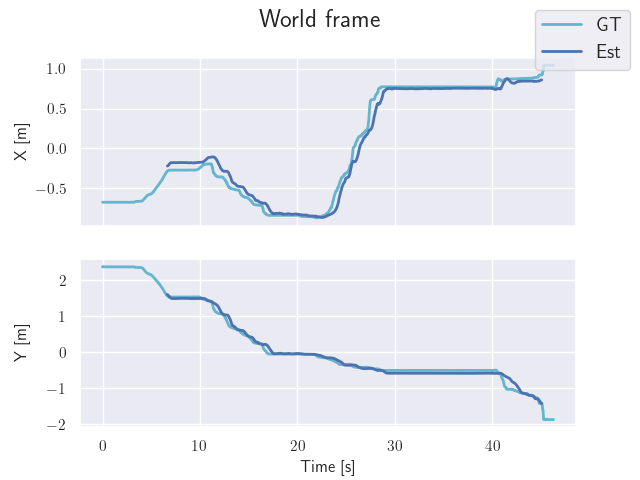

In [61]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_gt_track_coord[:,0], np_gt_track_coord[:,1],'-', lw=2, c='c')
axs[0].plot(np_track_coord[:,0], np_track_coord[:,1],'-', lw=2, c='b')
# axs[0].plot(np_fov[:,0], np_fov[:,1],'-', lw=2, c='g')

axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_gt_track_coord[:,0], np_gt_track_coord[:,2],'-', lw=2, c='c')
axs[1].plot(np_track_coord[:,0], np_track_coord[:,2],'-', lw=2, c='b')
# axs[1].plot(np_fov[:,0], np_fov[:,2],'-', lw=2, c='g')

axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["GT", "Est"] #, "Field of View"]
fig.legend(labels, loc='upper right', ncol=1, fontsize=14)
fig.suptitle('World frame', fontsize=18, weight="bold")
fig.align_ylabels(axs)

plt.show()


if input("Save fig?") == "y":
    plt.savefig("tracks_world_frame.svg")

# Camera coordinates

In [62]:

camera_coordinates_tria = b.message_by_topic('/search/tracks/camera_coordinates_tria')
df_camera_coordinates_tria = pd.read_csv(camera_coordinates_tria)

df_camera_coordinates_tria = rename_columns(df_camera_coordinates_tria[["Time", "x", "y", "z"]], ["x_tria", "y_tria", "z_tria"])

df_camera_coordinates_tria

,Time,x_tria,y_tria,z_tria
0,1.681804e+09,1.586110,-0.390493,2.488846
1,1.681804e+09,1.569278,-0.389957,2.485428
2,1.681804e+09,1.551018,-0.388719,2.477539
3,1.681804e+09,1.538127,-0.390145,2.478165
4,1.681804e+09,1.524845,-0.390145,2.478165
...,...,...,...,...
828,1.681804e+09,-1.587995,-0.304777,2.475235
829,1.681804e+09,-1.599935,-0.302124,2.475235
830,1.681804e+09,-1.611875,-0.299471,2.475235
831,1.681804e+09,-1.623815,-0.296817,2.475235


In [63]:
camera_coordinates_fov = b.message_by_topic('/search/tracks/camera_coordinates_fov')
df_camera_coordinates_fov = pd.read_csv(camera_coordinates_fov)

df_camera_coordinates_fov = rename_columns(df_camera_coordinates_fov[["Time", "x", "y", "z"]], ["x_fov", "y_fov", "z_fov"])

df_camera_coordinates_fov

,Time,x_fov,y_fov,z_fov
0,1.681804e+09,0.623964,-0.146511,2.488846
1,1.681804e+09,0.617168,-0.146310,2.485428
2,1.681804e+09,0.609832,-0.145846,2.477539
3,1.681804e+09,0.604613,-0.146399,2.478165
4,1.681804e+09,0.599245,-0.146399,2.478165
...,...,...,...,...
828,1.681804e+09,-0.611950,-0.113221,2.475235
829,1.681804e+09,-0.616787,-0.112190,2.475235
830,1.681804e+09,-0.621628,-0.111160,2.475235
831,1.681804e+09,-0.626474,-0.110129,2.475235


In [64]:
# Get tracks in image coordinates

est_tracks = b.message_by_topic('/search/tracks')
df_est_tracks = pd.read_csv(est_tracks)

df_est_tracks = rename_columns(df_est_tracks[["Time", "bounding_boxes"]], ["bbs"])

df_est_tracks = ret_track_df(df_est_tracks)

df_est_tracks

,Time,id,probability,Class,center_x,center_y
0,1.681804e+09,1,0.81,human,1240.5,218.5
1,1.681804e+09,1,0.81,human,1235.0,218.5
2,1.681804e+09,1,0.81,human,1230.0,218.5
3,1.681804e+09,1,0.81,human,1225.0,218.0
4,1.681804e+09,1,0.81,human,1220.0,218.0
...,...,...,...,...,...,...
828,1.681804e+09,1,0.81,human,47.5,250.0
829,1.681804e+09,1,0.81,human,43.0,251.0
830,1.681804e+09,1,0.81,human,38.5,252.0
831,1.681804e+09,1,0.81,human,34.0,253.0


In [65]:
df_merged_track_camera_coord = sync_dfs_based_on_time([df_camera_coordinates_fov, df_camera_coordinates_tria])


np_camera_coordinates_tria = get_np_arr_without_nan(df_merged_track_camera_coord, ["x_tria", "y_tria", "z_tria"], remove_identicals=False)
np_camera_coordinates_fov = get_np_arr_without_nan(df_merged_track_camera_coord, ["x_fov", "y_fov", "z_fov"], remove_identicals=False)

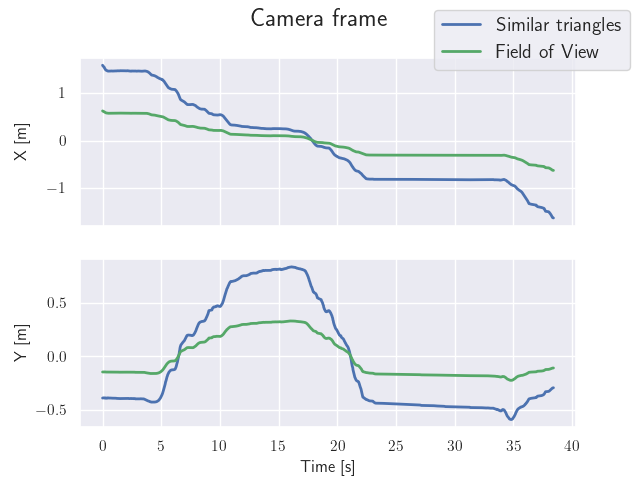

In [66]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(np_camera_coordinates_tria[:,0], np_camera_coordinates_tria[:,1],'-', lw=2, c='b')
axs[0].plot(np_camera_coordinates_fov[:,0], np_camera_coordinates_fov[:,1],'-', lw=2, c='g')

axs[0].set_ylabel('X [m]')
axs[0].grid(True)
axs[0].set_xticklabels([])


axs[1].plot(np_camera_coordinates_tria[:,0], np_camera_coordinates_tria[:,2],'-', lw=2, c='b')
axs[1].plot(np_camera_coordinates_fov[:,0], np_camera_coordinates_fov[:,2],'-', lw=2, c='g')

axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('Y [m]')
axs[1].grid(True)

handles, labels = axs[1].get_legend_handles_labels()
labels = ["Similar triangles", "Field of View"]
fig.legend(labels, loc='upper right', ncol=1, fontsize=14)
fig.suptitle('Camera frame', fontsize=18, weight="bold")
fig.align_ylabels(axs)

plt.show()


if input("Save fig?") == "y":
    plt.savefig("tracks_camera_frame.svg")


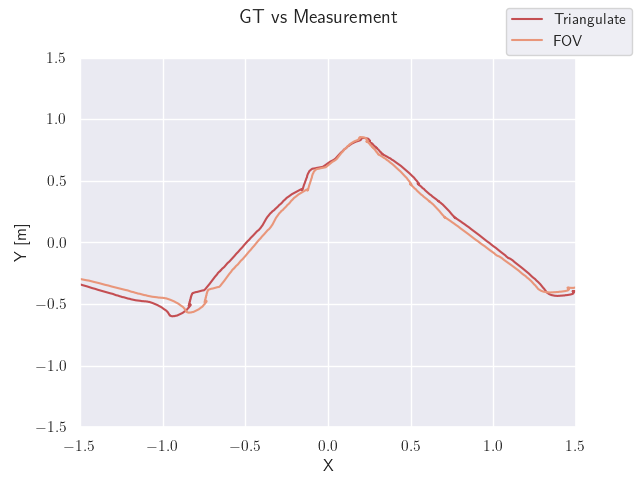

In [305]:
fig = plt.figure()

plt.plot(np_camera_coordinates_tria[:,1], np_camera_coordinates_tria[:,2],'-', ms=1, c='r')
plt.plot(np_camera_coordinates_fov[:,1], np_camera_coordinates_fov[:,2],'-', ms=1, c='darksalmon')

plt.xlabel("X")
plt.ylabel('Y [m]')
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
labels = ["Triangulate", "FOV"]
fig.legend(labels, loc='upper right', ncol=1)
fig.suptitle('GT vs Measurement', fontsize=14)
fig.align_ylabels(axs)